<img width="600" src="http://linux.ria.ua/img/articles/numberplate_detection/nomeroff_net.png" alt="Nomeroff Net. Automatic numberplate recognition system"/>

The example demonstrates license plate number detection.

In [1]:
# Import all necessary libraries.
import os
import sys
import json
import matplotlib.image as mpimg
from matplotlib import pyplot as plt

# Load default configuration file.
with open('../config/default.json') as data_file:
    config = json.load(data_file)
    
sys.path.append(os.path.abspath(config["NOMEROFF_NET"]["ROOT"]))

In [ ]:
# Import license plate recognition tools.
from NomeroffNet import  filters, RectDetector, TextDetector, StandartDetector, Detector

# Initialize npdetector with default configuration file.
nnet = Detector(config)
# Load weights in keras format.
nnet.loadModel()

# Initialize rect detector with default configuration file.
rectDetector = RectDetector(config["RECT_DETECTOR"])

# Initialize text detector.
textDetector = TextDetector(config["TEXT_DETECTOR"])

# Initialize standart detector.
standartDetector = StandartDetector()
standartDetector.load(os.path.join(config["NOMEROFF_NET"]["ROOT"], config["NP_STANDART_DETECTOR"]["MODEL_PATH"]))

Using TensorFlow backend.
/usr/local/lib64/python3.6/site-packages/keras/engine/saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/258946495.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


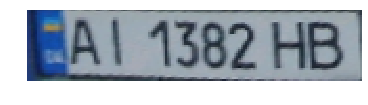

ukr2015
BA|1382HB


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/257445962.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


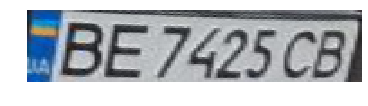

ukr2015
BE7425CB


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


images/258698277.jpeg


/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


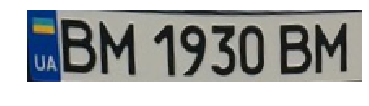

ukr2015
BM1930BM
images/258698277.jpeg


/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


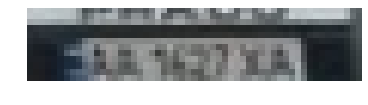

garbage

images/258698277.jpeg


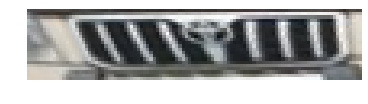

garbage



/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/example1.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


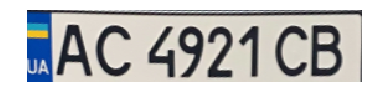

ukr2015
AC4921CB


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/247925366.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


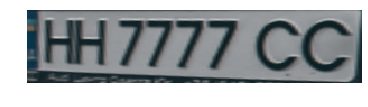

garbage



/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/250035439.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


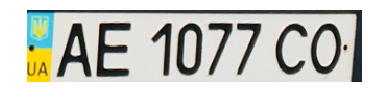

ukr2004
AE1077CO


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/250034513.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


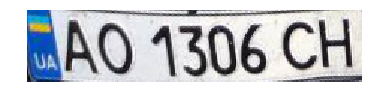

ukr2015
MAOQ1306CH


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/257445979.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


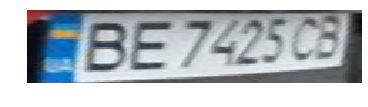

ukr2015
=BE7225C5)


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/259107471.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


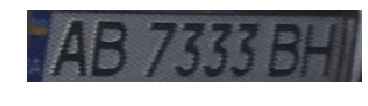

ukr2015
AB7333BH


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


images/example2.jpg


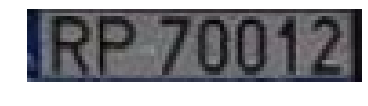

euro

images/example2.jpg


/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


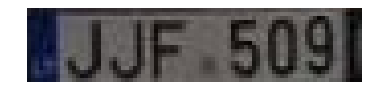

euro



/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/250024142.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


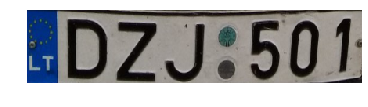

euro



/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/250019001.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


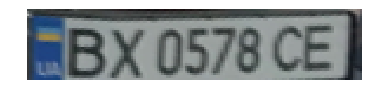

ukr2015
BX0578CE


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/247925361.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


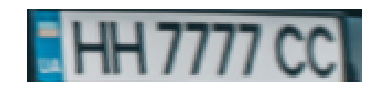

ukr2015
=HH7777¢


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


images/250021048.jpeg


/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


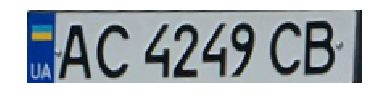

ukr2015
AC4249CB


/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:137: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib64/python3.6/site-packages/skimage/util/dtype.py:190: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))
/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount

images/258371761.jpeg


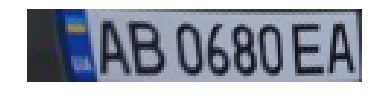

ukr2004
AR0680EA
images/258371761.jpeg


/usr/local/lib64/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib64/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


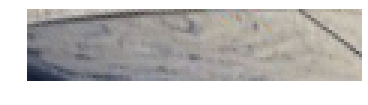

garbage

images/258371761.jpeg


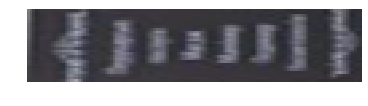

garbage



/usr/local/lib64/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [ ]:
# Walking through the ./examples/images/ directory and checking each of the images for license plates.
rootDir = 'images/'
arr_zones = []
for dirName, subdirList, fileList in os.walk(rootDir):
    for fname in fileList:
        img_path = os.path.join(dirName, fname)
        img = mpimg.imread(img_path)

        NP = nnet.detect([img])
        
        # Generate image mask.
        cv_img_masks = filters.cv_img_mask(NP)
        
        for img_mask in cv_img_masks:
            # Detect points.
            points = rectDetector.detect(img_mask, 3)
    
            # Split on zones
            zones = rectDetector.get_cv_zones(img, points)
            arr_zones += zones
            
            for zone in zones:
                # Show zone
                print(img_path)
                plt.axis("off")
                plt.imshow(zone)
                plt.show()
                
                # find standart
                standart = standartDetector.getLabels(standartDetector.predict(zone))
                print(standart)
                
                # find text with postprocessing by standart
                text = textDetector.detect(zone, standart)
                print(text)